# Price Prediction with Facebook's Prophet

Copyright ©2019 Andy Norris @ Irvine Algotrading

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

This notebook shall not be considered financial advice and is purely for financial research.

First, we import a few python packages.  You can attempt to !pip install ________  in a cell, sometimes it works nicely.

In [1]:
import pandas as pd
from fbprophet import Prophet

import pandas as pd
import matplotlib.pyplot as plt

import pandas_ta as ta
from alphaVantageAPI.alphavantage import AlphaVantage ##pip install alphaVantage-api##

Next we need to get some data to work with, using AlphaVantage's free API.
You'll need to go to their website and get your own API key, entering it below.
Adjust the export_path for the data to somewhere you can manage in your environment (I'm using the downloads folder).
The symbol='CW' is how you pick which ticker you are trying to analyze, 'DA' stands for daily adjusted data.
predper is how many days ahead (periods ahead) to give a predicted value for.

In [2]:
ticker='CW'
AV = AlphaVantage(
        api_key='PUT YOUR API KEY HERE',
        premium=False,       
        datatype='json',
        export=False,
        export_path= './export',
        output='csv',
        output_size='full',
        clean=True,
        proxy={})

df = AV.data(symbol=ticker, function='DA')
predper = 60 #number of days to predict ahead
print(f"Shape: {df.shape}")
df.set_index(['date'], inplace=True)
df.head()

Shape: (5033, 9)


open    high      low   close  adj_close   volume  dividend  \
date                                                                         
1999-10-11  36.6219  36.625  36.1250  36.125     7.5018  37200.0    0.0000   
1999-10-12  36.0000  36.000  35.6880  35.750     7.4239  13600.0    0.0000   
1999-10-13  35.5630  35.563  35.0000  35.000     7.2947  15600.0    0.0325   
1999-10-14  35.0000  35.000  34.0630  34.063     7.0993  16400.0    0.0000   
1999-10-15  34.1250  34.188  33.8772  33.875     7.0602   8800.0    0.0000   

            split_coefficient  
date                           
1999-10-11                1.0  
1999-10-12                1.0  
1999-10-13                1.0  
1999-10-14                1.0  
1999-10-15                1.0

The table above shows the very beginning cells in the dataframe, similar to an excel table.  Columns are labeled across the top.

As a matter of good housekeeping, we're going to fill any N/A fields with a 0, which helps avoid computational errors that are hidden deep inside a csv file sometimes.

In [3]:
df.fillna(0.0, inplace=True)

Next export the dataframe to a csv and store it in the folder you've been using.

In [4]:
df.to_csv ('./pricedataCW.csv', index = 'date', header=True)

Then read it back in to work with the csv file as a dataframe.  You will notice the use of usecols to only utilize the datestamp and the close price - this is to help mesh the file with FB Prophet properly.

In [5]:
df = pd.read_csv('pricedataCW.csv',
                usecols=['date','close'])
df.head()

date   close
0  1999-10-11  36.125
1  1999-10-12  35.750
2  1999-10-13  35.000
3  1999-10-14  34.063
4  1999-10-15  33.875

In [6]:
df.tail()

date   close
5028  2019-10-04  125.75
5029  2019-10-07  126.72
5030  2019-10-08  124.18
5031  2019-10-09  125.31
5032  2019-10-10  126.18

Now we have to rename our columns in our dataframe to appease the Prophet. 

In [7]:
df.columns = ['ds', 'y']

Here is where the magic begins.  Below is a model utilizing Prophet, and someday I'll update this to better explain what is exactly going on inside.  Their docs are pretty good and loads of people are talking about this package.  Most people were able to dramatically improve predictions with a number of simple tweaks beyond the default settings of their example notebook.

The goal will be to add a floor and ceiling to the prediction in order to prevent it from thinking it can predict negative values or price drops in excess of 60% within a day, for example.

This step can take a minute or two depending on your hardware.

In [8]:
m = Prophet(
    growth="linear",
    #holidays=holidays,
    #seasonality_mode="multiplicative",
    changepoint_prior_scale=30,
    seasonality_prior_scale=35,
    ###cap=3.00,
    ###floor=.65*125,
    holidays_prior_scale=20,
    daily_seasonality=False,
    weekly_seasonality=False,
    yearly_seasonality=False,
    ).add_seasonality(
        name='monthly',
        period=30.5,
        fourier_order=55
    ).add_seasonality(
        name='daily',
        period=1,
        fourier_order=15
    ).add_seasonality(
        name='weekly',
        period=7,
        fourier_order=20
    ).add_seasonality(
        name='yearly',
        period=365.25,
        fourier_order=20
    ).add_seasonality(
        name='quarterly',
        period=365.25/4,
        fourier_order=5,
        prior_scale=15)
m.fit(df)

Fitting is literally that simple.

Now, let's add cells to put our predictions into.  You'll notice the datestamp is ahead by the predper prediction period you chose earlier in the notebook.

In [9]:
future = m.make_future_dataframe(periods=predper)
future.tail()

ds
5088 2019-12-05
5089 2019-12-06
5090 2019-12-07
5091 2019-12-08
5092 2019-12-09

Now we need to produce a forecast from our data.

In [10]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds        yhat  yhat_lower  yhat_upper
5088 2019-12-05  139.331364  130.357945  148.327583
5089 2019-12-06  140.175092  131.586033  149.290569
5090 2019-12-07  139.172735  130.612177  147.822696
5091 2019-12-08  139.235934  130.941388  148.658245
5092 2019-12-09  138.716692  130.128260  147.665809

Let's plot this data!

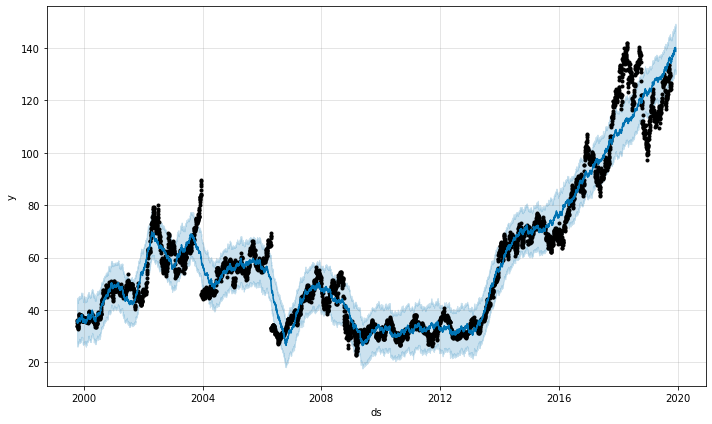

In [11]:
pd.plotting.register_matplotlib_converters()
fig1 = m.plot(forecast)

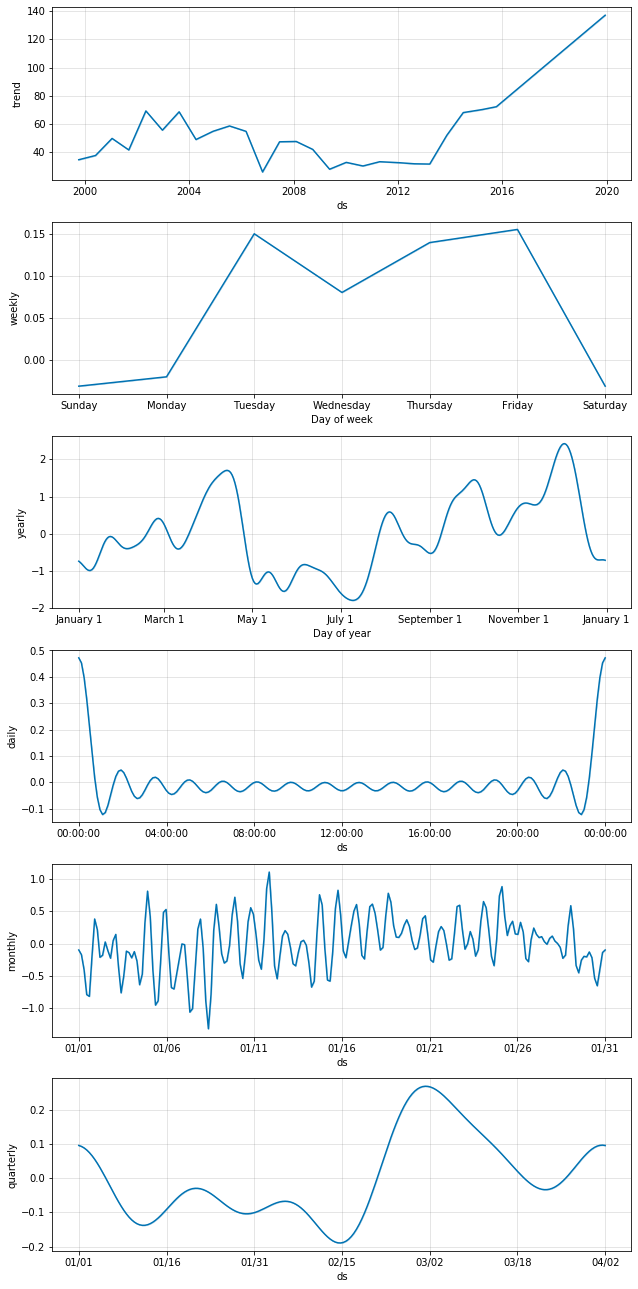

In [12]:
fig2 = m.plot_components(forecast)

We'll add an interactive plot with plotly to show off a bit.

In [13]:
from fbprophet.plot import plot_plotly
import plotly.offline as py
py.init_notebook_mode()

fig = plot_plotly(m, forecast)  # This returns a plotly Figure
py.iplot(fig)

We need to create a second dataframe, df2, to pull the stock info back in again separately from the original dataframe so we have a fresh copy to work with.  This can probably be foregone in future versions of this notebook, but it was helpful during the initial setup of everything to separate this out.  

Note the differences of df2, closedf2, etc.

In [14]:
df2 = AV.data(symbol=ticker, function='DA') # Daily Adjusted
df2.name = ticker
df2.set_index(['date'], inplace=True)
df2.drop(['dividend', 'split_coefficient'], axis=1, inplace=True) if 'dividend' in df2.columns and 'split_coefficient' in df2.columns else None

opendf2 = df2['open']
closedf2 = df2['close']
volumedf2 = df2['volume']

Now, we need yet another dataframe to pull in our forecast data and cut off the future dates.  This is for the trend_return function, if the datestamps differ between the two then it fails to analyze properly.  

In [15]:
df3 = forecast[['ds','yhat']]
df3.tail()

ds        yhat
5088 2019-12-05  139.331364
5089 2019-12-06  140.175092
5090 2019-12-07  139.172735
5091 2019-12-08  139.235934
5092 2019-12-09  138.716692

Above you can see dates are well beyond the current date, iloc takes care of this for us.  :-predper is the marker to select the data from the bottom of the dataframe, for "predper" values from the bottom.  So if the prediction is 60 days, then this removes the bottom 60 pieces of data, matching the datestamps of df2 so the two can be compared with trend_return (from pandas-ta).

In [16]:
df3 = df3.iloc[:-predper]
df3.columns = ['date','close']
df3.set_index(['date'], inplace=True)
df3.tail()

close
date                  
2019-10-04  135.761439
2019-10-07  135.318892
2019-10-08  135.536570
2019-10-09  134.933314
2019-10-10  135.152228

In [17]:
df2.tail()

open    high     low   close  adj_close    volume
date                                                           
2019-10-04  125.43  126.41  125.08  125.75     125.75  187700.0
2019-10-07  125.48  127.12  125.21  126.72     126.72  267300.0
2019-10-08  125.34  125.35  123.51  124.18     124.18  191800.0
2019-10-09  125.35  125.74  123.85  125.31     125.31   93000.0
2019-10-10  125.14  126.97  125.14  126.18     126.18   85800.0

Above you can see df2.tail and df3.tail have the same datestamps, so we're ready to go!

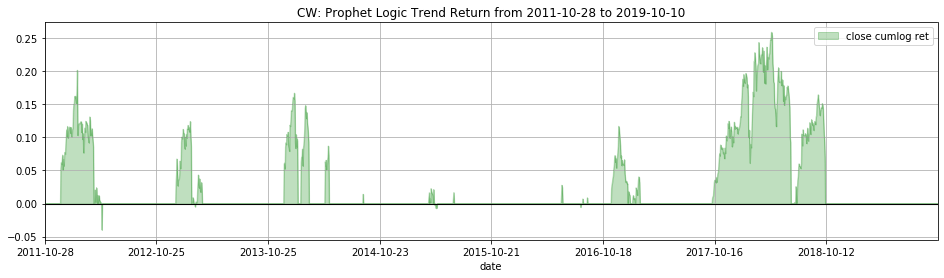

In [18]:
last_ = df2.shape[0]

def stratty(cumulative=True, last=last_):
    """A very basic analysis of the closing price being greater than each moving average"""
    last = last if last is not None else df2.shape[0]
    closedf2 = df2['close']
        
    pred = df3['close']
    
    tdf2 = pd.DataFrame({
        f"{pred.name} cumlog ret": ta.trend_return(closedf2, pred < .95*closedf2, cumulative=cumulative),
        })
    tdf2.set_index(closedf2.index, inplace=True)
    window = tdf2.tail(last)
    title = f"{df2.name}: Prophet Logic Trend Return from {window.index[0]} to {window.index[-1]}"
    window.plot.area(figsize=(16, 4), color=['green', 'orange', 'yellow'], linewidth=1, alpha=0.25, title=title, stacked=False, grid=True).axhline(y=0, color="black", lw=1.1)

stratty(last=2000) #last 2000 days of activity to show in the cumlog return plot

And there you have it, we take the cumulate return of the logic detailed in tdf2.  This calculates the return as if you held while this condition was true.  There is a lot of interpretation and understanding for this particular result plot.  We are working on a better means of backtesting at this time, but for now, this will have to be the general indication of how the logic can or can't produce a profit.  Try messing with the pred > .95*closedf2 in different ways to see what happens!

This notebook runs start to finish in 3 min 53 sec on my MSI laptop with an i7 processor.

Please be careful when considering using this!  While this is a fun exercise, by no means is this any sort of guarantee to be a profitable or successful strategy.